In [1]:
import sys
sys.path.append('..')

import tomodpdt

import numpy as np
import time
import matplotlib.pyplot as plt

import deeplay as dl

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

c:\Users\Fredrik\Documents\GitHub\TomoDpDt\Notebooks\..\deeptrack_t\__init__.py:14: UserWarning: TensorFlow is detected in your environment. DeepTrack2 version 2.0++ no longer supports TensorFlow. If you need TensorFlow support, please install the legacy version 1.7 of DeepTrack2:

    pip install deeptrack==1.7

For more details, refer to the DeepTrack documentation.
  warnings.warn(


In [2]:
DEV = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', DEV)

Using device: cuda


In [ ]:
plotly_3d = False # Do interactive 3D plots with plotly
save_folder = None # Save the results to a folder

if save_folder is not None:
    import os
    os.makedirs(save_folder, exist_ok=True)

## 1 - Import 3D volume data

In this example we load in a 3D volume consisting of small gaussian blobs placed randomly inside the volume. The volume is 64x64x64 voxels in size, but can be up/downsampled to any size.



In [4]:
volume = tomodpdt.VOL_GAUSS_MULT

In [5]:
print(f"Shape of the volume: {volume.shape}")

Shape of the volume: (64, 64, 64)


In [6]:
# Visualize the volume in 3D space - needs plotly and ipywidgets
if plotly_3d:
    tomodpdt.plotting.visualize_3d_volume(volume)

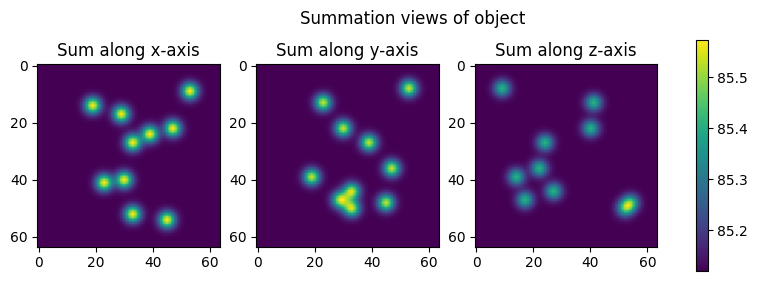

In [7]:
tomodpdt.plotting.plot_sum_object(volume)

## 2 - Choose imaging modality
We create images that are projections of the volume along a certain axis (in this case z-axis) by taking the sum of the pixel values along that axis.

There are two main types of imaging modalities here:

- `Sum3d2d`: Sum of pixel values along an axis
- `SumAvgWeighted3d2d`: Sum of pixel values along an axis weighted by the distance from the top of the volume

In [ ]:
from tomodpdt.imaging_modality_torch import SumAvgWeighted3d2d, Sum3d2d

# Define the model and which axis to sum over
sum_model = Sum3d2d(dim=-1)

In [9]:
test_object, q_gt, projections, imaging_model = tomodpdt.simulate.create_data(
    volume=volume, # The volume we want to reconstruct
    image_modality=sum_model, # We use the sum model
    rotation_case='random_sinusoidal', # We rotate the object around 1 main axis, but the other 2 axes are also non-zero an
    samples=400, # Number of projections
    duration=2 # Duration is the number of full revolutions
    )

Simulating... 25.0%
Simulating... 50.0%
Simulating... 75.0%


and for sanity check we can see that we have the following shapes...

In [21]:
print(f"Shape of the test_object: {test_object.shape}")
print(f"Shape of the q_gt: {q_gt.shape}")
print(f"Shape of the projections: {projections.shape}")

Shape of the test_object: torch.Size([64, 64, 64])
Shape of the q_gt: torch.Size([400, 4])
Shape of the projections: torch.Size([400, 1, 64, 64])


and the frames look like...

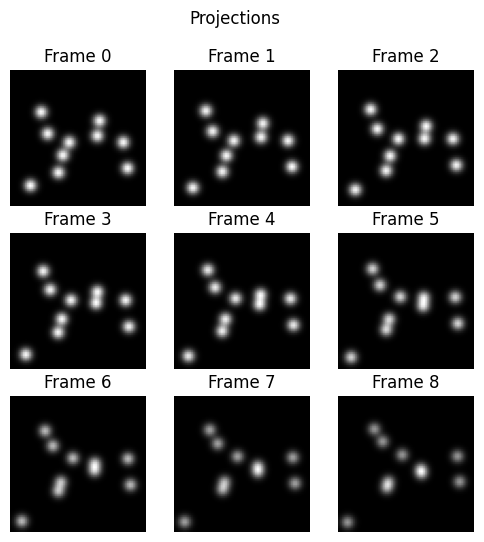

In [10]:
tomodpdt.plotting.plot_grid33_frames(projections, title="Projections")

and the quaternions...

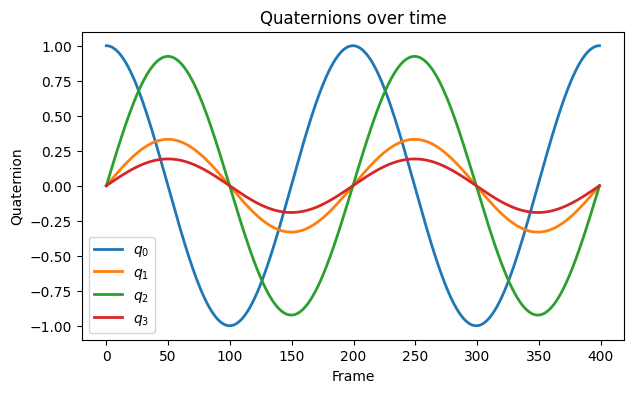

In [11]:
tomodpdt.plotting.plot_quaternions(q_gt)

## 3 - Tomographic reconstruction

### 3.1 - Set up the tomographic reconstruction class

In [12]:
N=volume.shape[0]

# Create the tomography model
tomo = tomodpdt.Tomography(
    volume_size=(N, N, N), # The size of the volume
    initial_volume='refraction', # 'refraction' since we are optimizing the refractive index
    rotation_optim_case='basis', # 'basis' or 'quaternion'
    imaging_model=sum_model, # The imaging model
    )


### 3.2 - Initialize the parameters by producing a initial guess for the rotation parameters and the volume

In [13]:
# Initialize the parameters
tomo.initialize_parameters(projections, normalize=True)

c:\Users\Fredrik\miniconda3\envs\pytorchdt\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.


┏━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name                ┃ Type                 ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ encoder             │ Sequential           │ 79.5 K │
│ 1 │ fc_mu               │ MultiLayerPerceptron │ 32.8 K │
│ 2 │ fc_var              │ MultiLayerPerceptron │ 32.8 K │
│ 3 │ fc_dec              │ MultiLayerPerceptron │ 51.3 K │
│ 4 │ decoder             │ Sequential           │ 61.0 K │
│ 5 │ reconstruction_loss │ BCELoss              │      0 │
│ 6 │ train_metrics       │ MetricCollection     │      0 │
│ 7 │ val_metrics         │ MetricCollection     │      0 │
│ 8 │ test_metrics        │ MetricCollection     │      0 │
│ 9 │ optimizer           │ Adam                 │      0 │
└───┴─────────────────────┴──────────────────────┴────────┘

Trainable params: 257 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 257 K                                                                                                
Total estimated model params size (MB): 1

c:\Users\Fredrik\miniconda3\envs\pytorchdt\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

c:\Users\Fredrik\miniconda3\envs\pytorchdt\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
c:\Users\Fredrik\miniconda3\envs\pytorchdt\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (13) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


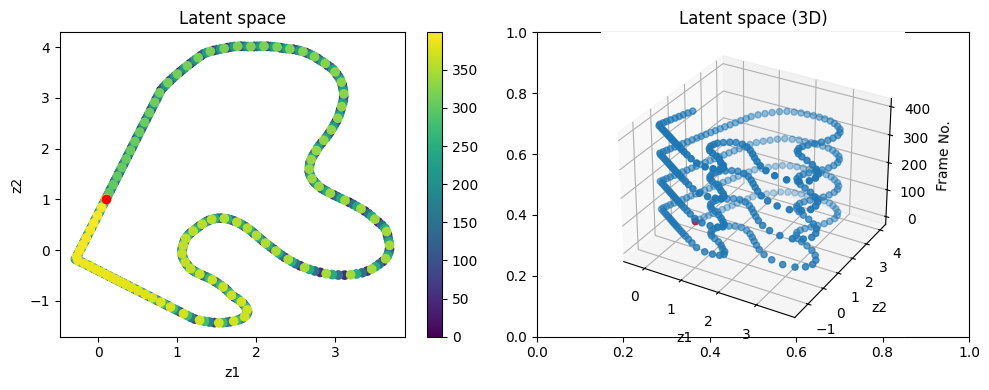

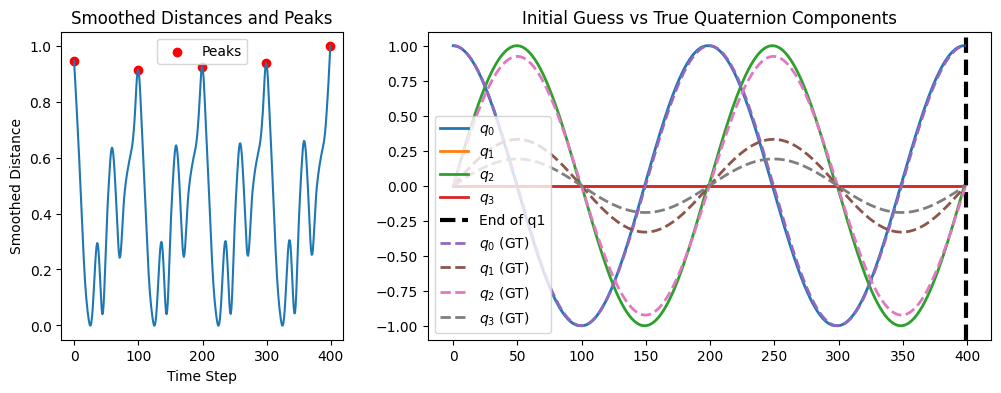

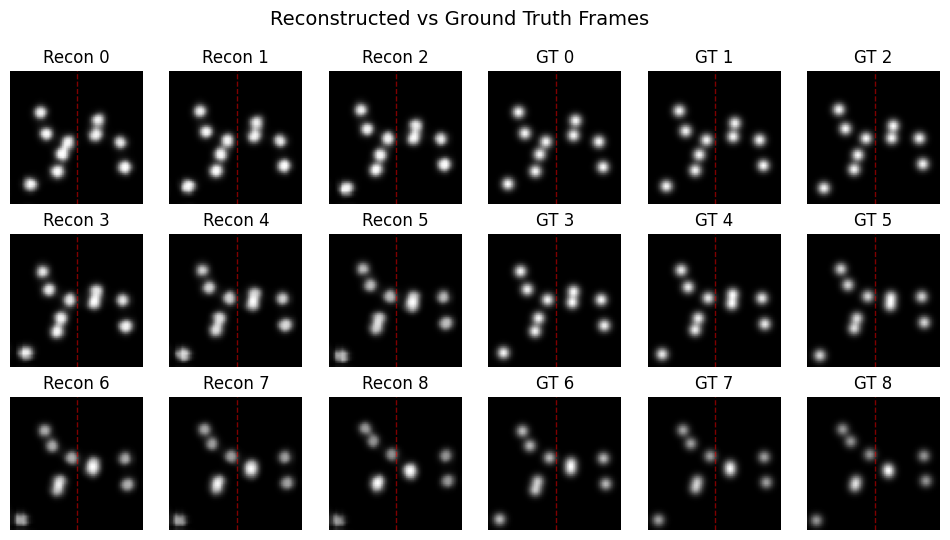

In [14]:
tomodpdt.plotting.plots_initial(tomo, gt=q_gt.to('cpu'), save_folder=save_folder)

### 3.3 - Optimize the volume alone first

In [15]:
N = len(tomo.frames) # Number of frames
idx = torch.arange(N) # Index of frames

In [16]:
epochs_object_only = 100
batch_size_object_only = 64

c:\Users\Fredrik\miniconda3\envs\pytorchdt\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name          ┃ Type                   ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ vae_model     │ VariationalAutoEncoder │  257 K │
│ 1 │ encoder       │ Sequential             │ 79.5 K │
│ 2 │ fc_mu         │ MultiLayerPerceptron   │ 32.8 K │
│ 3 │ imaging_model │ Sum3d2d                │      0 │
│ 4 │ train_metrics │ MetricCollection       │      0 │
│ 5 │ val_metrics   │ MetricCollection       │      0 │
│ 6 │ test_metrics  │ MetricCollection       │      0 │
│ 7 │ optimizer     │ Adam                   │      0 │
│   │ other params  │ n/a                    │  149 K │
└───┴───────────────┴────────────────────────┴────────┘

Trainable params: 262 K                                                                                            
Non-trainable params: 257 K                                                                                        
Total params: 519 K                                                                                                
Total estimated model params size (MB): 2

c:\Users\Fredrik\miniconda3\envs\pytorchdt\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (7) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training time:  0.3279906392097473  minutes


c:\Users\Fredrik\miniconda3\envs\pytorchdt\Lib\site-packages\deeplay\callbacks\history.py:151: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale(yscale)


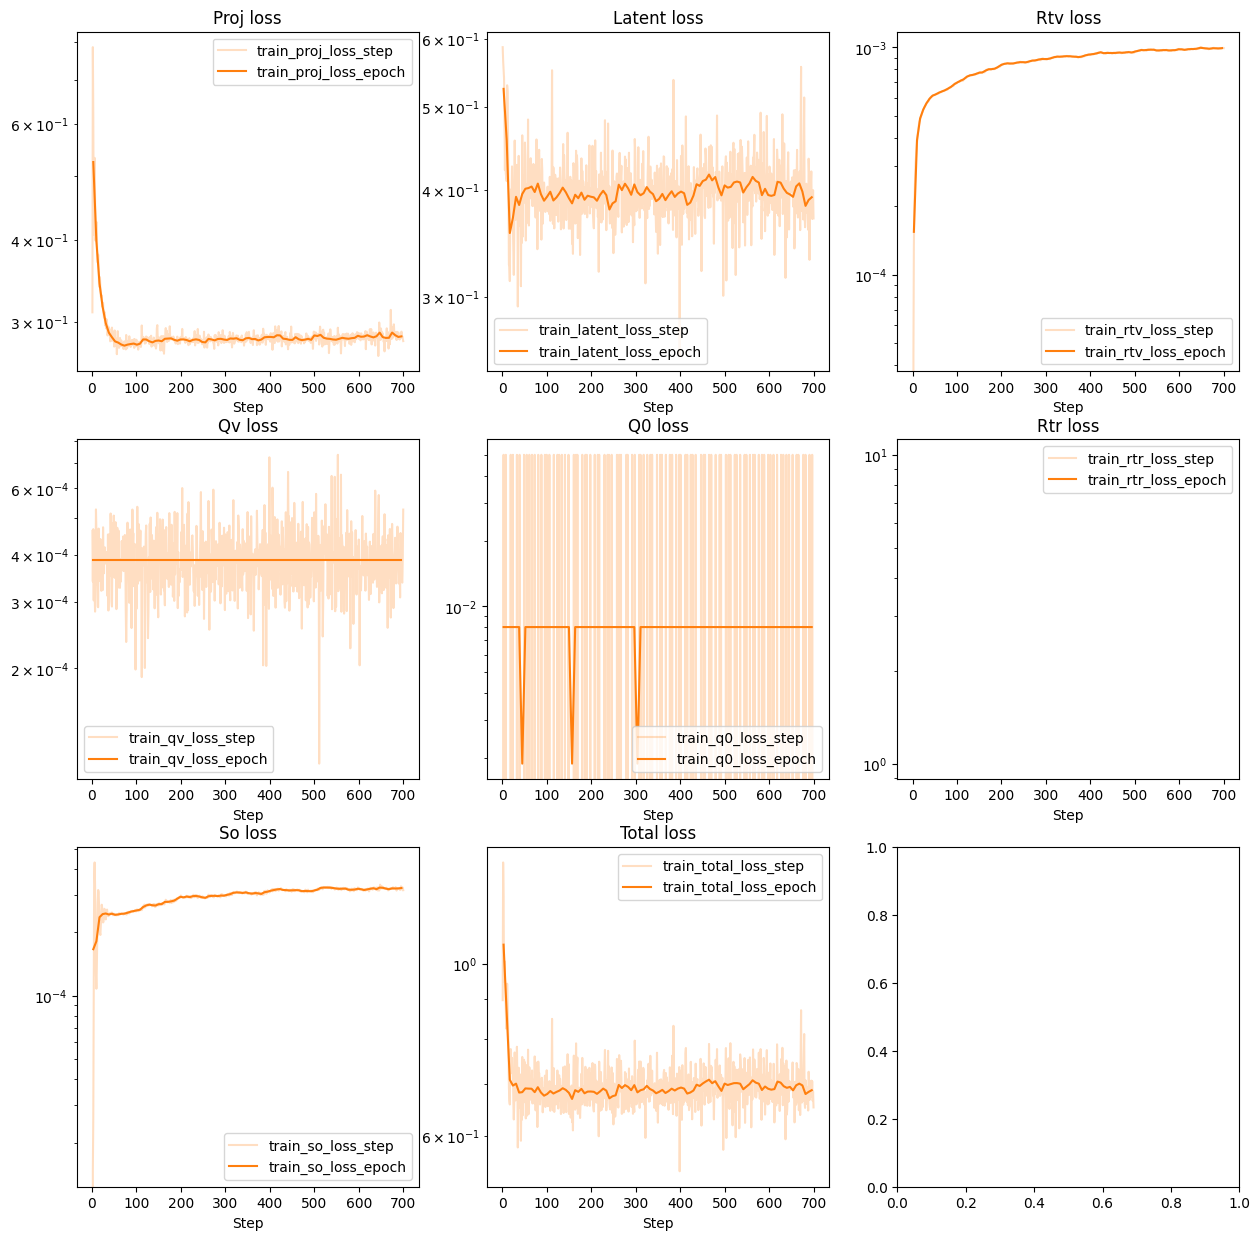

In [17]:
# Toggle the gradients of the quaternion parameters
tomo.toggle_gradients_quaternion(False)

# Move the model to device
tomo.move_all_to_device(DEV)

# Train the model
start_time = time.time()
trainer = dl.Trainer(max_epochs=epochs_object_only, accelerator="auto", log_every_n_steps=10)
trainer.fit(tomo, DataLoader(idx, batch_size=batch_size_object_only , shuffle=True))
print("Training time: ", (time.time() - start_time) / 60, " minutes")

# Plot the training history
try:
    trainer.history.plot()
except:
    print("No history to plot...")

### 3.4 - Optimize the 3D volume and the rotation parameters

In [18]:
epochs_object_rot = 1250
batch_size_object_rot = 128

┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name          ┃ Type                   ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ vae_model     │ VariationalAutoEncoder │  257 K │
│ 1 │ encoder       │ Sequential             │ 79.5 K │
│ 2 │ fc_mu         │ MultiLayerPerceptron   │ 32.8 K │
│ 3 │ imaging_model │ Sum3d2d                │      0 │
│ 4 │ train_metrics │ MetricCollection       │      0 │
│ 5 │ val_metrics   │ MetricCollection       │      0 │
│ 6 │ test_metrics  │ MetricCollection       │      0 │
│ 7 │ optimizer     │ Adam                   │      0 │
│   │ other params  │ n/a                    │  149 K │
└───┴───────────────┴────────────────────────┴────────┘

Trainable params: 262 K                                                                                            
Non-trainable params: 257 K                                                                                        
Total params: 519 K                                                                                                
Total estimated model params size (MB): 2

c:\Users\Fredrik\miniconda3\envs\pytorchdt\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training time:  20.063214675585428  minutes


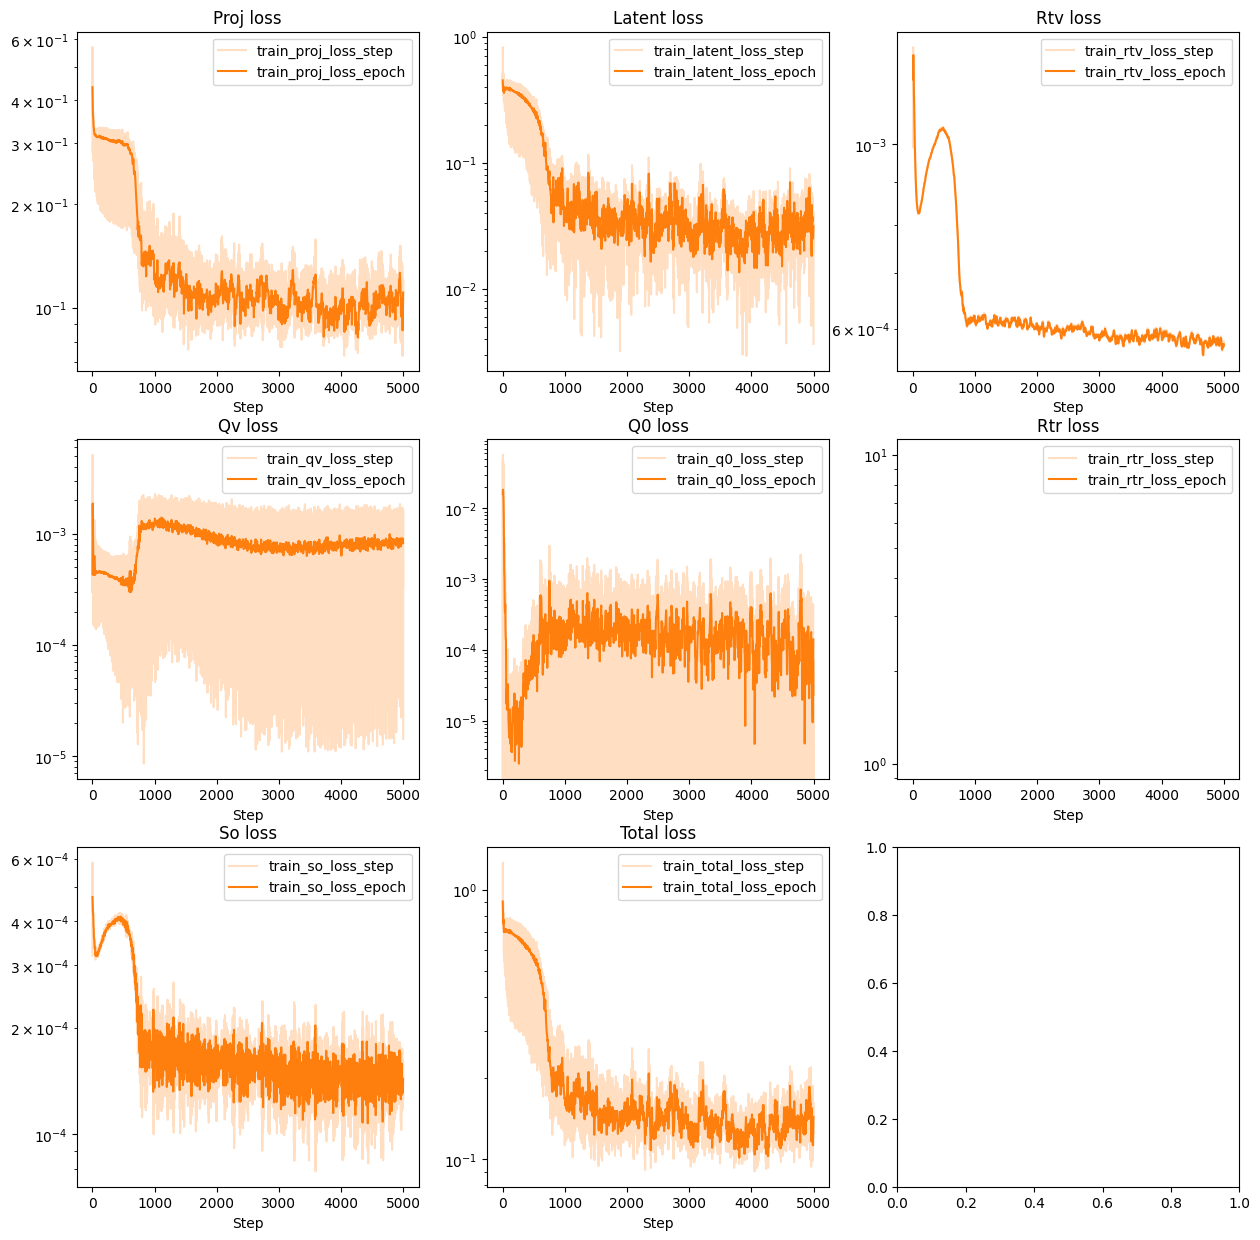

In [19]:
# Toggle the gradients of the quaternion parameters
tomo.toggle_gradients_quaternion(True)

# Move the model to device
tomo.move_all_to_device(DEV)

# Train the model
start_time = time.time()
trainer = dl.Trainer(max_epochs=epochs_object_rot, accelerator="auto", log_every_n_steps=10)
trainer.fit(tomo, DataLoader(idx, batch_size=batch_size_object_rot, shuffle=False))
print("Training time: ", (time.time() - start_time) / 60, " minutes")

# Plot the training history
try:
    trainer.history.plot()
except:
    print("No history to plot...")

## 4.0 - Visualize the reconstructed volume and the parameters

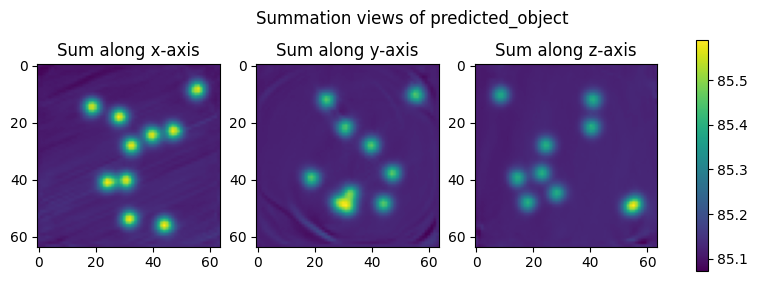

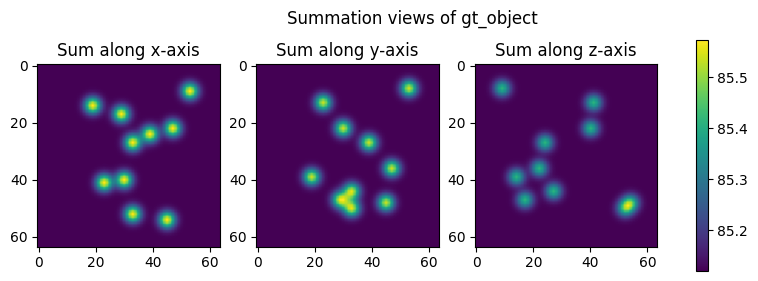

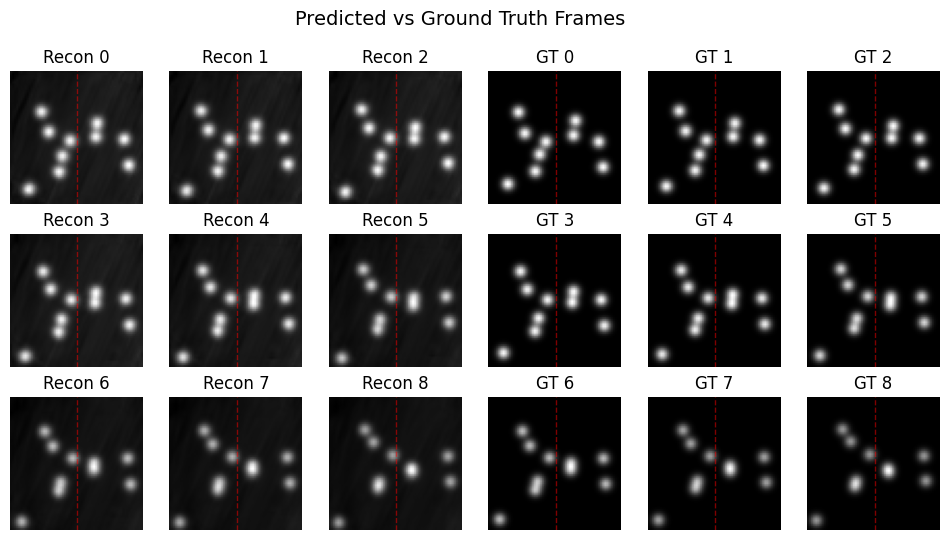

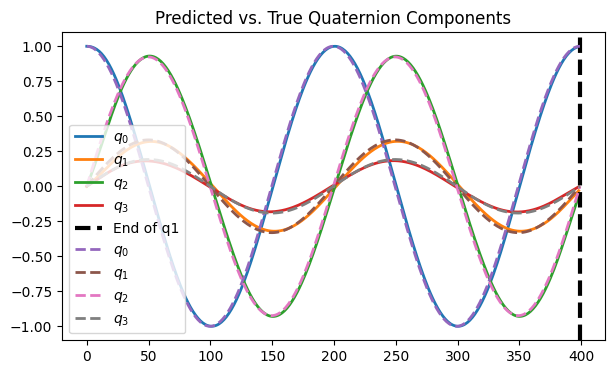

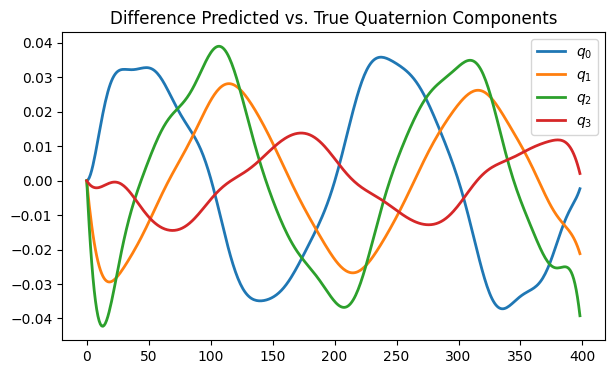

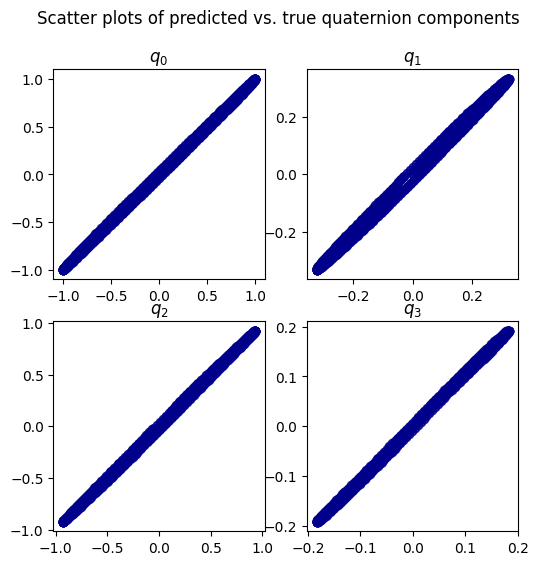

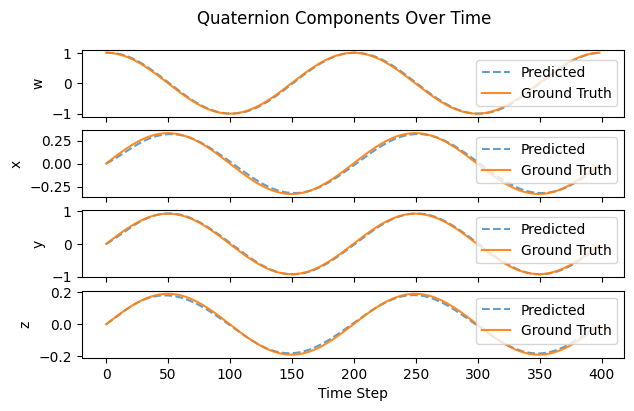

In [20]:
# Move it to the GPU if possible for faster plotting
tomo.move_all_to_device(DEV)

# Visualize the final volume and rotations.
tomodpdt.plotting.plots_optim(tomo, gt_q=q_gt.to('cpu'), gt_v=test_object.to('cpu'), plot_3d=plotly_3d, save_folder=save_folder)

## 5 - Save the reconstructed volume and the parameters

In [22]:
from medmnist import NoduleMNIST3D

In [24]:
nodm = NoduleMNIST3D(root='data', split='train', download=True)

100%|██████████| 29299364/29299364 [00:08<00:00, 3318950.54it/s]


AttributeError: 'NoduleMNIST3D' object has no attribute 'shape'